In [1]:
# do all the imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from IPython.display import display, Math
import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage.transform import rotate, rescale, warp, SimilarityTransform
from skimage import exposure

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# calculate branching ratios
# source of values: https://pdg.lbl.gov/2020/listings/rpp2020-list-z-boson.pdf
br_ee=3.3632
br_mm=3.3662
br_tt=3.3696
br_invisible=20.
br_hadron=69.911

br_vis_total=br_ee+br_mm+br_tt+br_hadron
br_ee_vis=br_ee/br_vis_total
br_mm_vis=br_mm/br_vis_total
br_tt_vis=br_tt/br_vis_total
br_hadron_vis=br_hadron/br_vis_total

# calculate entries and branching ratios in category arrays
def count_entries(cat):
    total=len(cat)
    factor=100./total

    unique, counts = np.unique(cat, return_counts=True)
    counts_out=[]
    ratios_out=[]
    if 0 in unique:
        iq=np.where(unique==0)[0]
        counts_out.append(counts[iq][0])
        ratios_out.append(counts[iq][0]*factor)
    else:
        counts_out.append(0)
        ratios_out.append(0)

    if 1 in unique:
        ie=np.where(unique==1)[0]
        counts_out.append(counts[ie][0])
        ratios_out.append(counts[ie][0]*factor)
    else:
        counts_out.append(0)
        ratios_out.append(0)

    if 2 in unique:
        im=np.where(unique==2)[0]
        counts_out.append(counts[im][0])
        ratios_out.append(counts[im][0]*factor)
    else:
        counts_out.append(0)
        ratios_out.append(0)

    if 3 in unique:
        it=np.where(unique==3)[0]
        counts_out.append(counts[it][0])
        ratios_out.append(counts[it][0]*factor)
    else:
        counts_out.append(0)
        ratios_out.append(0)
    return counts_out, ratios_out

# simple text to number with two decimals
def tts(value):
    return "{:.2f}".format(value)

# show overview with branching ratios including theoretical values
def check_br(names, *arrays, show_theory=True):
    rs=[]
    cs=[]
    for iset in arrays:
        c, r = count_entries(iset)
        cs.append(c)
        rs.append(r)  
        
    labels = ["q", "e", "m", "t"]
    theory = np.array([br_hadron_vis, br_ee_vis, br_mm_vis, br_tt_vis])*100

    out1 = "\t"
    out2 = "#Evt:\t"
    for iset in range(len(arrays)):
        out1 += names[iset] + "\t\t\t"
        out2 += str(len(arrays[iset])) + "\t\t\t"
    if show_theory:
        out1 += "Theorie\t\t\t"
    print(out1)
    print(out2)
    print("")

    for itype in range(len(labels)):
        out=labels[itype]+":\t"
        for iset in range(len(rs)):
            out += str(cs[iset][itype]) + "\t" + tts(rs[iset][itype]) + "%\t\t"
        if show_theory:
            out += tts(theory[itype]) + "%"
        print(out)

In [3]:
# convert signs to respective numbers
# q=0, e=1, m=2, t=3
def sign_to_number(sign):
    if sign=="q":
        return 0
    elif sign=="e":
        return 1
    elif sign=="m":
        return 2
    elif sign=="t":
        return 3
    else:
        raise RuntimeError("\"" + str(sign) + "\" is not a valid identifier for decay classes")

# convert numbers to respective signs
def number_to_sign(number):
    if number==0:
        return "q"
    elif number==1:
        return "e"
    elif number==2:
        return "m"
    elif number==3:
        return "t"
    else:
        raise RuntimeError("\"" + str(number) + "\" is not a valid identifier for decay classes")

# show confusion matrix
# adapted from https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/metrics/_plot/confusion_matrix.py#L12
def plot_confusion_matrix(true, predicted):
    import matplotlib.colors as colors
    cmat=tf.math.confusion_matrix(true, predicted, num_classes=None, weights=None, dtype=tf.dtypes.int32, name=None).numpy()
    fig, ax = plt.subplots()

    # cm = np.where(cmat==0, .1, cmat)
    cm = cmat
    n_classes = cm.shape[0]
    im_ = ax.imshow(cm+1, interpolation='nearest', cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=np.max(cmat)))
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    from itertools import product
    text_ = np.empty_like(cm, dtype=object)
    thresh = (cm.max()+1 + cm.min()+1) / 2.0

    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text_cm = format(cm[i, j], '.0f')
        text_[i, j] = ax.text(j, i, text_cm, ha="center", va="center", color=color)

    display_labels = ["q", "e", "m", "t"]
    fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
            yticks=np.arange(n_classes),
            xticklabels=display_labels,
            yticklabels=display_labels,
            ylabel="True label",
            xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation="horizontal")
    figure_ = fig
    ax_ = ax
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.show()

# show training metrics
# adapted from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#check_training_history
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color="C0", label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color="C0", linestyle="--", label='Val')
        plt.xlabel('Epoch')
        # plt.ylabel(name)
        plt.title(metric)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()
    plt.show()

In [6]:
cat_filepath = "all_events.csv"
picture_filepath = "all-events/"

# load file with previously determined categories of all images
df = pd.read_csv(cat_filepath, delimiter=";", header=None)

images=[]       #nparray of all images
names=[]        #array of all filenames
categories=[]   #nparray with the categories (q=0, e=1, m=2, t=3)

# helper to add images to both image and category arrays
def add_image(filename):
    global images, temp_categories, picture_filepath

    # add image with matching filename to list
    images.append(plt.imread(picture_filepath+filename))

    # add category to list
    categories.append(sign_to_number(sign))


# loop over all entries of the .csv
for filename in df[0]:
    # get category of respective filename
    sign=df[df[0].str.match(filename)].iat[0,1]

    # load picture without overload
    add_image(filename)

    names.append(filename)

# for filename in df[0]:
#     sign=df[df[0].str.match(filename)].iat[0,1]
#     print(filename, sign)

# convert lists to numpy arrays
images=np.array(images)
categories=np.array(categories)
print(len(images), "Bilder geladen")

609 Bilder geladen


In [7]:
# Augment the dataset by copying the pictures with an integer factor rotating and/or flipping them randomly

# factor is integer: all categories are augmented with same factor
# factor is sequence with length 3: last 3 categories are augmented with given factors
# factor is sequence with length 4: al categories are augmented with given factors

# rotate images by random angle and flip randomly
def rot_mirr_eq(image):
    angle = np.random.randint(0, 360)
    mirror = np.random.randint(0, 2)
    image_out = rotate(image, angle)
    if mirror==1:
        image_out=np.fliplr(image_out)
    return exposure.rescale_intensity(image_out)

# loop over all images and multiply images for better training
def augment_rot_mirr(images, categories, factor, rot_mirr=True):
    if hasattr(factor, "__len__") and (not isinstance(factor, str)):
        if len(factor) == 4:
            pass
        elif len(factor) == 3:
            factor = [1, factor[0], factor[1], factor[2]]
        else:
            raise ValueError("Dimension of factor is not equal to 4.")
    else:
        factor = [factor, factor, factor, factor]

    # loop over the images until enough copies are created
    categories_out = []
    images_out = [] 
    for i_events in range(len(categories)):
        for i_factor in range(factor[categories[i_events]]):
            if rot_mirr:
                images_out.append(rot_mirr_eq(images[i_events]))
            else:
                images_out.append(images[i_events])
            categories_out.append(categories[i_events])
                
    # ensure numpy arrays
    categories_out = np.array(categories_out)
    images_out = np.array(images_out)

    # ensure random distribution
    images_out, categories_out = shuffle(images_out, categories_out)
    return images_out, categories_out

In [8]:
# create training, validation and test datasets
# test data are separated before data augmentation
# data is shuffled randomly in all datasets!

aug_start=datetime.datetime.now()
print("Starte Verfielfältigung...")

train_of_total_ratio = 0.2
val_of_total_ratio = 0.1
random_state=None
shuffle_entries=True

# split train/vali and test data
X_tv, X_test, y_tv, y_test = train_test_split(images, categories, test_size=1-(train_of_total_ratio+val_of_total_ratio), random_state=random_state, shuffle=shuffle_entries)

# save copy for augmentation evaluation
X_tv_unaug, y_tv_unaug = X_tv, y_tv
X_test_unaug, y_test_unaug = X_test, y_test

# augment data
X_tv, y_tv = augment_rot_mirr(X_tv, y_tv, [10, 120, 120, 120])

# split train/vali in test and validation data
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=val_of_total_ratio/(train_of_total_ratio+val_of_total_ratio), random_state=random_state, shuffle=shuffle_entries)

# ensure randomness
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

aug_end=datetime.datetime.now()
print("Verfielfältigung abgeschlossen, hat", aug_end-aug_start, "gedauert")

print("Train:\t", len(y_train))
print("Val:\t", len(y_val))
print("Test:\t", len(y_test))

Starte Verfielfältigung...
Verfielfältigung abgeschlossen, hat 0:01:05.462025 gedauert
Train:	 2680
Val:	 1340
Test:	 427


In [9]:
# show distribution
check_br(["orig","tv_unau","tv   ","train","vali","test"], categories, y_tv_unaug, y_tv, y_train, y_val, y_test)

	orig			tv_unau			tv   			train			vali			test			Theorie			
#Evt:	609			182			4020			2680			1340			427			

q:	529	86.86%		162	89.01%		1620	40.30%		1090	40.67%		530	39.55%		367	85.95%		87.38%
e:	24	3.94%		5	2.75%		600	14.93%		399	14.89%		201	15.00%		19	4.45%		4.20%
m:	27	4.43%		6	3.30%		720	17.91%		474	17.69%		246	18.36%		21	4.92%		4.21%
t:	29	4.76%		9	4.95%		1080	26.87%		717	26.75%		363	27.09%		20	4.68%		4.21%


In [16]:
# create model: 4 convolutional layers + 3 pooling layers -> flatten -> 2 fully connected layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 64)         

In [11]:
# train model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train_start=datetime.datetime.now()
print("Starte Training...")
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))
train_end=datetime.datetime.now()
print("Training abgeschlossen, hat", train_end-train_start, "gedauert")

Starte Training...
Epoch 1/3
84/84 [==============================] - 39s 468ms/step - loss: 0.8929 - accuracy: 0.5776 - val_loss: 0.3844 - val_accuracy: 0.8627
Epoch 2/3
84/84 [==============================] - 38s 450ms/step - loss: 0.1938 - accuracy: 0.9321 - val_loss: 0.1229 - val_accuracy: 0.9604
Epoch 3/3
84/84 [==============================] - 42s 500ms/step - loss: 0.1259 - accuracy: 0.9552 - val_loss: 0.1068 - val_accuracy: 0.9537
Training abgeschlossen, hat 0:02:01.855946 gedauert


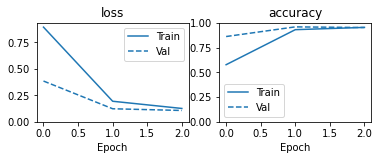

In [12]:
# show training metrics
plot_metrics(history)

In [13]:
# predict and get most likely prediction with softmax and argmax
predictions = model.predict(X_test)
score = tf.nn.softmax(predictions)
out=np.argmax(score, axis=1)

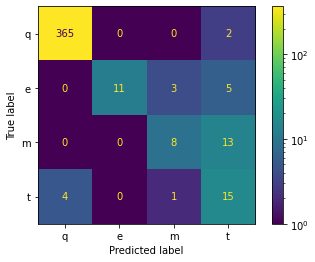

In [14]:
# show confusion matrix
plot_confusion_matrix(y_test, out)

In [15]:
# calculate branching ratios with test data (which is independent of training and validation data)
print("Training time:", train_end-train_start, "\n")
check_br(["orig","tv_unau","tv   ","train","vali","test","pred"], categories, y_tv_unaug, y_tv, y_train, y_val, y_test, out)

Training time: 0:02:01.855946 

	orig			tv_unau			tv   			train			vali			test			pred			Theorie			
#Evt:	609			182			4020			2680			1340			427			427			

q:	529	86.86%		162	89.01%		1620	40.30%		1090	40.67%		530	39.55%		367	85.95%		369	86.42%		87.38%
e:	24	3.94%		5	2.75%		600	14.93%		399	14.89%		201	15.00%		19	4.45%		11	2.58%		4.20%
m:	27	4.43%		6	3.30%		720	17.91%		474	17.69%		246	18.36%		21	4.92%		12	2.81%		4.21%
t:	29	4.76%		9	4.95%		1080	26.87%		717	26.75%		363	27.09%		20	4.68%		35	8.20%		4.21%


Training time: 0:02:46.959190 

Ratios:
	orig			tv_unau			tv   			train			vali			test			pred			Theorie			
#Evt:	609			182			4680			3120			1560			427			427			

q:	529	86.86%		156	85.71%		1560	33.33%		1015	32.53%		545	34.94%		373	87.35%		370	86.65%		87.38%
e:	24	3.94%		6	3.30%		720	15.38%		474	15.19%		246	15.77%		18	4.22%		18	4.22%		4.20%
m:	27	4.43%		12	6.59%		1440	30.77%		993	31.83%		447	28.65%		15	3.51%		19	4.45%		4.21%
t:	29	4.76%		8	4.40%		960	20.51%		638	20.45%		322	20.64%		21	4.92%		20	4.68%		4.21%

Metrics:


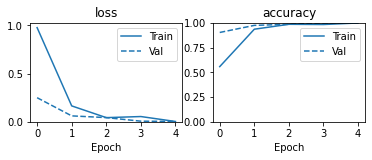


Confusion Matrix:


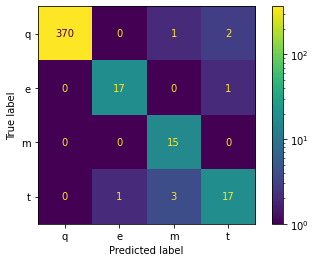

In [94]:
# training overview
print("Training time:", train_end-train_start, "\n")
print("Ratios:")
check_br(["orig","tv_unau","tv   ","train","vali","test","pred"], categories, y_tv_unaug, y_tv, y_train, y_val, y_test, out)
print("")
print("Metrics:")
plot_metrics(history)
print("")
print("Confusion Matrix:")
plot_confusion_matrix(y_test, out)

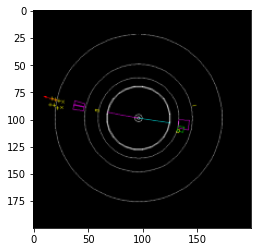

Picture was predicted as q but is t
Scores: tf.Tensor([9.7413230e-01 4.2716364e-18 3.2122650e-14 2.5867689e-02], shape=(4,), dtype=float32)


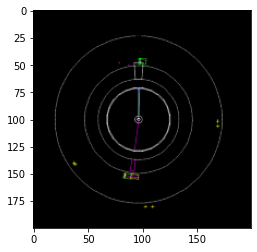

Picture was predicted as q but is t
Scores: tf.Tensor([7.7762455e-01 3.9192528e-15 2.2660567e-09 2.2237542e-01], shape=(4,), dtype=float32)


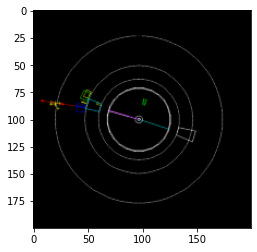

Picture was predicted as q but is t
Scores: tf.Tensor([6.2474394e-01 2.7685101e-17 4.2867650e-14 3.7525606e-01], shape=(4,), dtype=float32)


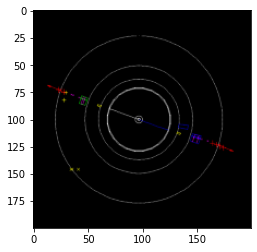

Picture was predicted as t but is m
Scores: tf.Tensor([5.6645799e-02 8.6095126e-14 5.2432838e-04 9.4282985e-01], shape=(4,), dtype=float32)


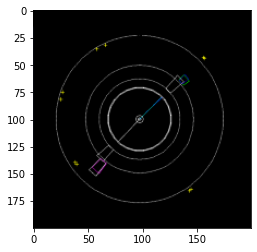

Picture was predicted as t but is e
Scores: tf.Tensor([1.5410909e-04 1.2527964e-08 1.9289004e-08 9.9984586e-01], shape=(4,), dtype=float32)


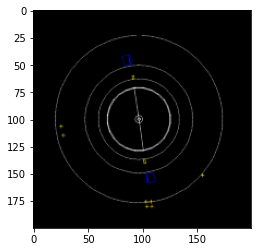

Picture was predicted as m but is t
Scores: tf.Tensor([2.3546352e-05 1.6445540e-13 9.9339700e-01 6.5794168e-03], shape=(4,), dtype=float32)


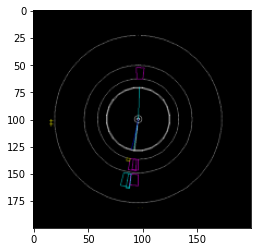

Picture was predicted as q but is t
Scores: tf.Tensor([8.9702040e-01 1.7036870e-16 2.7190424e-13 1.0297958e-01], shape=(4,), dtype=float32)


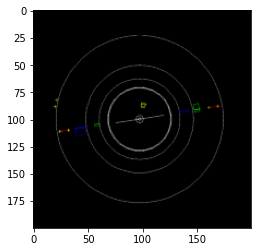

Picture was predicted as t but is m
Scores: tf.Tensor([9.9713244e-02 1.4674945e-11 5.1967159e-04 8.9976710e-01], shape=(4,), dtype=float32)


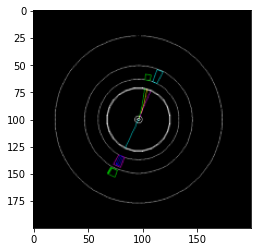

Picture was predicted as q but is t
Scores: tf.Tensor([9.9383378e-01 2.2072316e-22 1.8701662e-17 6.1662477e-03], shape=(4,), dtype=float32)


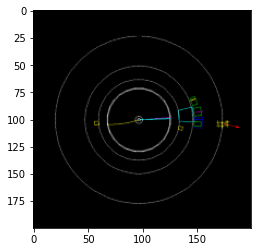

Picture was predicted as q but is t
Scores: tf.Tensor([8.9869636e-01 1.5390299e-18 6.1317637e-14 1.0130361e-01], shape=(4,), dtype=float32)


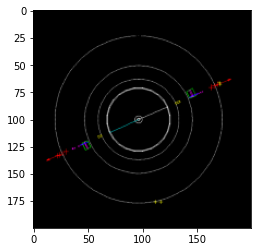

Picture was predicted as t but is m
Scores: tf.Tensor([3.5082209e-03 1.0351889e-14 1.4405262e-04 9.9634773e-01], shape=(4,), dtype=float32)


In [14]:
# show all wrongly predicted events
def show_image(id, images):
    # plt.imshow(images[i].reshape((200,200,1)), cmap=plt.cm.gray)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.show()
    
# for i in range(len(out)):
for i in range(len(out)):
    if out[i]!=y_test[i]:
        show_image(i, X_test)
        print("Picture was predicted as", number_to_sign(out[i]), "but is", number_to_sign(y_test[i]))
        print("Scores:", score[i])